<a href="https://colab.research.google.com/github/karelyrodri/Image-Steganography/blob/main/Image_Steganography_KR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Steganography

---

## Project Objective:
Implement and analyze performance of various image steganography algorithms including LSB, F5, and Deep Learning techniques. The evaluation of processed images will be contingent upon imperceptibility. The unperceivable or undetected change in the image after encrypting and embedding the secret message. The metrics are defined as Robustness, Mean Square Error (MSE), Peak Signal to Noise Ratio (PSNR), Normalized Cross Correlation (NCC), and Structured Similarity Index Measure (SSIM).


## Steganographic Process

Image steganography is the process of concealing secret information in an image in which is not visible to the human eye. The sender begins with the secret message, a secret key, and an image of their choosing to undergo an encoding process to produce an image nearly identical to it. The reciever will be able to retrieve the embedding secret message upon supplying the sent image with the corresponding key.

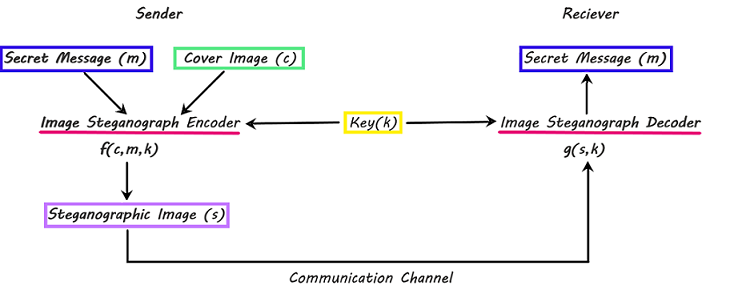

# Import Libraries 

In [1]:
pip install pycrypto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 446 kB 5.3 MB/s 
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp37-cp37m-linux_x86_64.whl size=499932 sha256=b544afc08c21edd2e82b6553e7b970cc516ff4ab767b92559d1bbc31e049ddea
  Stored in directory: /root/.cache/pip/wheels/cf/85/ba/bbd7c96add459de7598fb424e5ff2309baf2095c844ac0f191
Successfully built pycrypto


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import math
from Crypto.Cipher import AES
import base64

# Load Data 

In [3]:
hydrangea = np.array(Image.open('Hydrangea.jpg'))
silo = np.array(Image.open('Silo.jpg'))
glass = np.array(Image.open('Stained_Glass.jpg'))

# Metrics 

## Robustness 
The ability of the embedded data to remain intact undergoing transformations, filtering, sharpening, blurring, added random noise, rotations,scaling, cropping, and lossy compression.

**Goal:** the entropy between probability distribution of the cover and altered steganographic image is smaller than ℇ. This will befine whether it is ℇ-secure or not.

$$D(PD_c//PD_s) = ∫PD_c\log\left(\dfrac{PD_c}{PD_s}\right) \le ℇ$$



*   ℇ denotes the message space
*   steganographic image
*   List item




## Mean Square Error
The average squared difference between original image and altered steganographic image.

**Goal:** lower MSE indicates lower error between hidden image and cover image

$$MSE = \dfrac{1}{mn}\sum\limits_{i = 0}^{m-1}\sum\limits_{j = 0}^{n-1}\left[C(i,j)-S(i,j)\right]^2$$

*  _m_ denotes image rows
*  _n_ denotes image columns
*  _C(i,j)_ denotes pixel value of original cover image
*  _S(i,j)_ denotes pixel value of steganographic image 



In [ ]:
#inputs are np.array represenatyion of an images 
def MSE(cover, stegano):
  MSE = np.square((cover - stegano)).mean()
  return MSE 

##  PSNR - Peak Signal to Noise Ratio 
The ratio between maximum power of a signal and the power of corrupting noise regarding the quality of the compressed steganographic image compared to the origial.

**Goal:** high PSNR value indicates greater similarities of the steganographic image compared to the original. Imperceptibilty is achieve if PSNR is above 36 dB

$$PSNR = 20\log_{10}\left(\dfrac{MAX_c} {\sqrt{MSE}}\right)$$

*  $MAX_c$ denotes maximum possible pixel value of the original cover image
*   _MSE_ denotes Mean Square Error




In [ ]:
def PSNR(MSE):
  if MSE == 0:
    #There is no noise 
    return 100
  PSNR = 20 * math.log10(255 / math.sqrt(MSE))
  return PSNR 

## NCC - Normalized Cost Correlation 
Evaluates degree of closeness between the cover image and steganographic image.

**Goal:** A value closer to 1 indicates the images higher similarity.

$$NCC = \dfrac{\sum\limits_{i = 1}^{m}\sum\limits_{j = 1}^{n}C(i,j)* S(i,j)}{\sum\limits_{i = 1}^{m}\sum\limits_{j = 1}^{n}C(i,j)^2}$$

*  _m_ denotes image rows
*  _n_ denotes image columns
*  _C(i,j)_ denotes pixel value of original image
*  _S(i,j)_ denotes pixel value of steganographic image 


In [ ]:
def NCC(cover, stegano):
  NCC = (cover * stegano).sum() / np.square(cover).sum()
  return NCC

## SSIM - Structured Similarity Index Measure
Evaluates level of structural simiarity between cover image and steganpgraphic image. 

**Goal:** greater values closer to 1 represent higher similarities 

$$SSIM = \dfrac{(2μ_cμ_s + c_1)(2σ_{cs}+c_2)}{(μ_c^2μ_s^2 + c_1)(σ_c^2+σ_s^2+c_2)}$$


* c denotes the cover image
* s denotes the steganographic image
*   μ denotes pixel sample mean of c, s respectively 
*   σ denotes the variance of c, s respectively
* $σ_{cs}$ denotes the covariance of c and s
* $σ^2$ denotes the mean variance of c, s respectively 
* $c_1, c_2$ denotes varibales to stabilize division in weak denominator events




In [ ]:
def SSIM(cover, stegano):
  c_mu = cover.mean()
  s_mu = stegano.mean()
  c_var = np.square(np.var(cover))
  s_var = np.square(np.var(stegano))
  cs_covar = np.cov(cover, stegano)
  c1 = (0.01 * 255)**2
  c2 = (0.03 * 255)**2
  numerator = (2 * c_mu * s_mu + c1) * (2 * + c2 )
  denominator = ((np.square(c_mu) * np.square(s_mu)) + c1)  * (c_var + s_var + c2)
  SSIM = numerator / denominator
  return SSIM

# LSB - Least Significant Bit 
 LSB Steganography is a spatial domain technique in which the secret message will be embedded by altering the right most bits of the RBG pixels that make up the image data. By modifying only the least significants bits, we will achieve minimal impact in the overall apearance of the image. 
 
Spatial domain methods directly alter the pixel data to conceal the hidden message. 




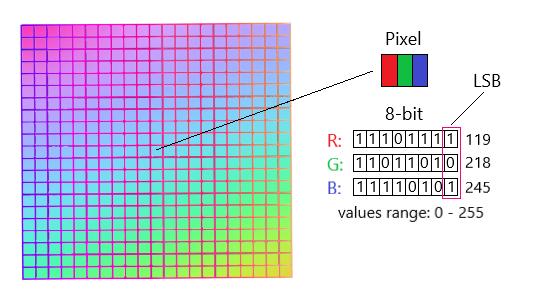

**AES Encryption based LSB Algorithm**

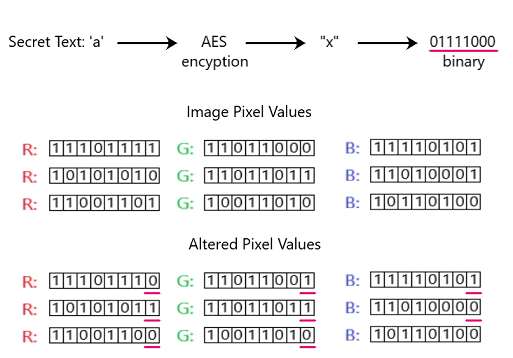

## Encryption

HELP Convert secret message to binary
> **Input:** secret - String   

> **Output:** binarySecrets - string made up of binary representation for each character of the inputted string 

In [4]:
def msgToBinary(secret):
  binarySecrets = []
  for ch in secret:
    charToBinary = "{:08b}".format(ord(ch))
    binarySecrets.append(charToBinary)
  return "".join(binarySecrets)

In [58]:
def LSB_encrypt(secret, cover, key):
  #pad key, length must be of multiples of 16
  secret += (16 - len(secret) % 16) * " "
  cipher = AES.new(bytes(key, 'utf-8'),  AES.MODE_ECB)
  encryptedMsg = base64.b64encode(cipher.encrypt(secret))

  binary = msgToBinary(encryptedMsg.decode("ascii") + "$+0p")
  # $+0p will serve as our delimiter value used in decrypting

  stegano = cover.copy()
  i, j, b = 0, 0, 0
  while(b < len(binary)):
    pixels = stegano[i][j]
    for rgb in range(0,3):
      if b < len(binary):
        msgVal = binary[b]
        binary_value = "{0:b}".format(pixels[rgb])
        changeBit = binary_value[:-1] + msgVal
        stegano[i][j][rgb] = int(changeBit, 2)
        b += 1
    i += 1
    j += 1

  return stegano

## Decryption

Convert secret binary to secret message   
> **Input:**  binarySecrets - List of string binary representations 

> **Output:**  secret - String

In [6]:
def binaryToMsg(binarySecrets):
  secret = []
  for binaryStr in binarySecrets:
    secret.append(chr(int(binaryStr, 2)))
  return "".join(secret)

In [68]:
def LSB_decrypt(stegano, key):
  delimiter = "$+0p"
  i, j = 0, 0
  stop = False
  curBinaryVal = []
  binarySecrets = []
  while(not stop):
    pixels = stegano[i][j]
    for value in pixels:

      if len(curBinaryVal) >= 8:
        binaryChar = "".join(curBinaryVal)
        if len(binarySecrets) >= 4 and binaryToMsg(binarySecrets[-4:]) == delimiter:
          stop = True
          binarySecrets = binarySecrets[:-4]
          break
        else:
          binarySecrets.append(binaryChar)
          curBinaryVal = []
      
      curBinaryVal.append("0" if value % 2 == 0 else "1")

    i += 1
    j += 1
  secret = binaryToMsg(binarySecrets)
  msg = base64.b64decode(bytes(secret, 'utf-8'))
  cipher = AES.new(bytes(key, 'utf-8'),  AES.MODE_ECB)
  decryptedMsg = cipher.decrypt(msg).rstrip()
  
  return decryptedMsg.decode("ascii")

## Visualization

### Image 1

Encrypt secret message in cover image 

In [ ]:
key = "0123456789012345"
secret_msg = "I miss the Silo BeanI miss the Silo BeanI miss the Silo BeanI miss the Silo Bean"

In [ ]:
hydrangea_stegano = LSB_encrypt(secret_msg, hydrangea, key)

Cover image and Steganographic image visual comparison

Text(0.5, 1.0, 'Steganographic Image')

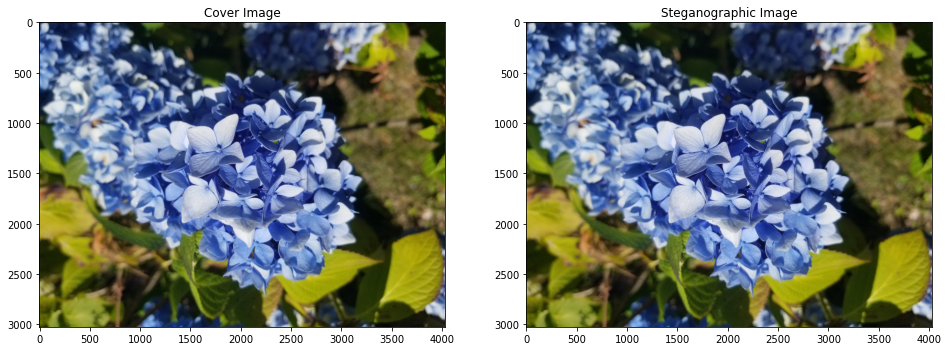

In [152]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(hydrangea)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(hydrangea_stegano)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(LSB_decrypt(hydrangea_stegano, key))

### Image 2

Encrypt secret message in cover image 

In [ ]:
key = "0123456789012345"
secret_msg = "I miss the Silo BeanI miss the Silo BeanI miss the Silo BeanI miss the Silo Bean"

In [69]:
silo_stegano = LSB_encrypt(secret_msg, silo, key)

Cover image and Steganographic image visual comparison

Text(0.5, 1.0, 'Steganographic Image')

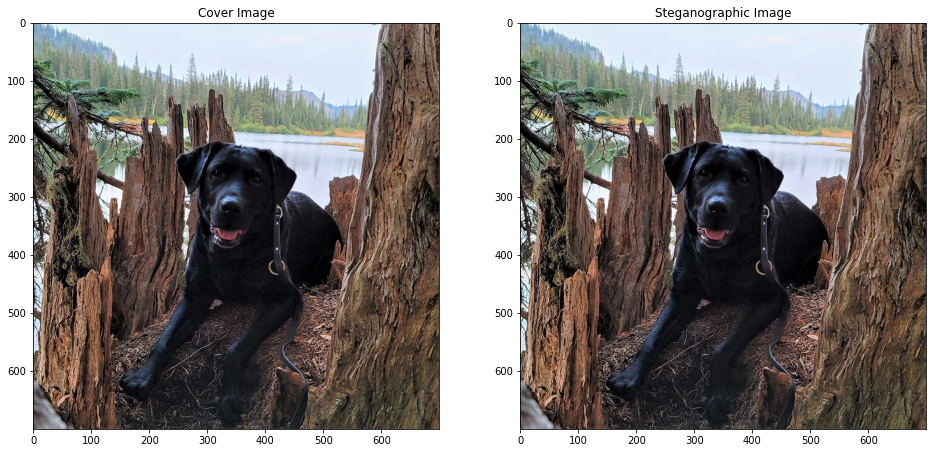

In [9]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(silo)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(silo_stegano)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [70]:
print(LSB_decrypt(silo_stegano, key))

I miss the Silo BeanI miss the Silo BeanI miss the Silo BeanI miss the Silo Bean


### Image 3

Encrypt secret message in cover image 

In [ ]:
key = "0123456789012345"
secret_msg = "I miss the Silo BeanI miss the Silo BeanI miss the Silo BeanI miss the Silo Bean"

In [ ]:
glass_stegano = LSB_encrypt(secret_msg, glass, key)

Cover image and Steganographic image visual comparison

Text(0.5, 1.0, 'Steganographic Image')

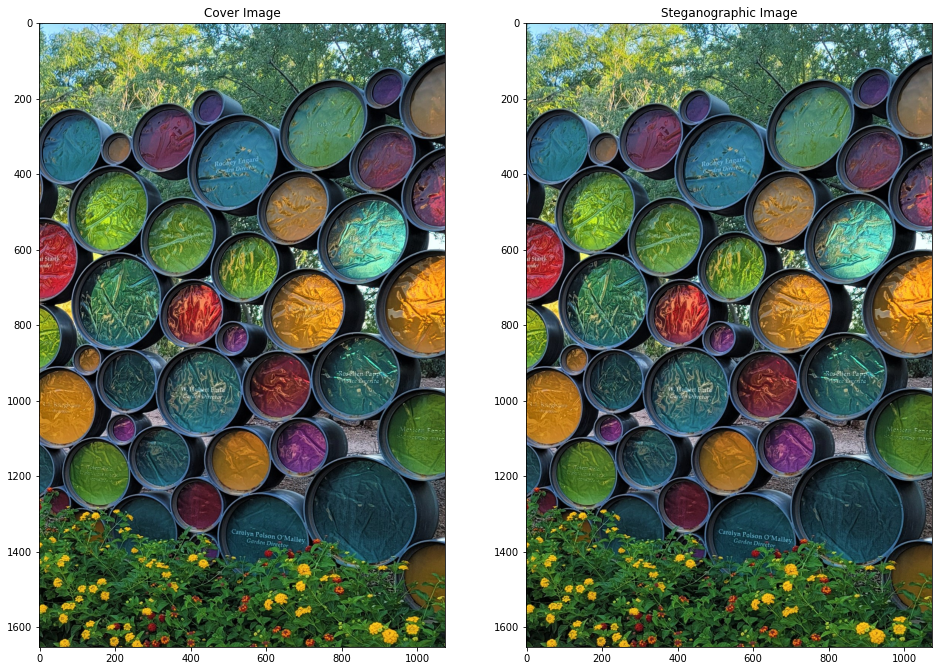

In [153]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(glass)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(glass_stegano)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(LSB_decrypt(glass_stegano, key))

# F5
F5 Image Steganography algorithm is a transform domain technique based on matrix encoding of the secret message. The algorithm produces a new shuffling key based off of the orginal inputted key that generates the pseudo-random Discrete Cosine Transform (DCT) coefficients used in the encoding process. F5 relies on shuffling to achieve Permutation Straddling which scatters the image changes of secret message all throughout. The quantized DCT coefficients are based on Huffman's lossless data compression algorithm to transform the brightness values into frequency coefficients.

A transform domain method is characterized by the transformation of the spatial domain to the frequency domain used for the embedding of the hidden message. 

## Encryption

## Decryption

## Visualization

### Image 1

### Image 2

### Image 3

# Deep Learning 

## Encryption

## Decryption

## Visualization

### Image 1

### Image 2

### Image 3

# Image Steganography Technique Evaluation

### Image 1

### Image 2

### Image 3

# References